In [1]:
import numpy as np

l = 100
x, y = np.indices((l, l))

center1 = (28, 24)
center2 = (40, 50)
center3 = (67, 58)
center4 = (24, 70)

radius1, radius2, radius3, radius4 = 16, 14, 15, 14

circle1 = (x - center1[0]) ** 2 + (y - center1[1]) ** 2 < radius1**2
circle2 = (x - center2[0]) ** 2 + (y - center2[1]) ** 2 < radius2**2
circle3 = (x - center3[0]) ** 2 + (y - center3[1]) ** 2 < radius3**2
circle4 = (x - center4[0]) ** 2 + (y - center4[1]) ** 2 < radius4**2

In [2]:
img = circle1 + circle2 + circle3 + circle4

# We use a mask that limits to the foreground: the problem that we are
# interested in here is not separating the objects from the background,
# but separating them one from the other.
mask = img.astype(bool)

img = img.astype(float)
img += 1 + 0.2 * np.random.randn(*img.shape)

In [3]:
from sklearn.feature_extraction import image

graph = image.img_to_graph(img, mask=mask)

In [4]:
graph.data = np.exp(-graph.data / graph.data.std())

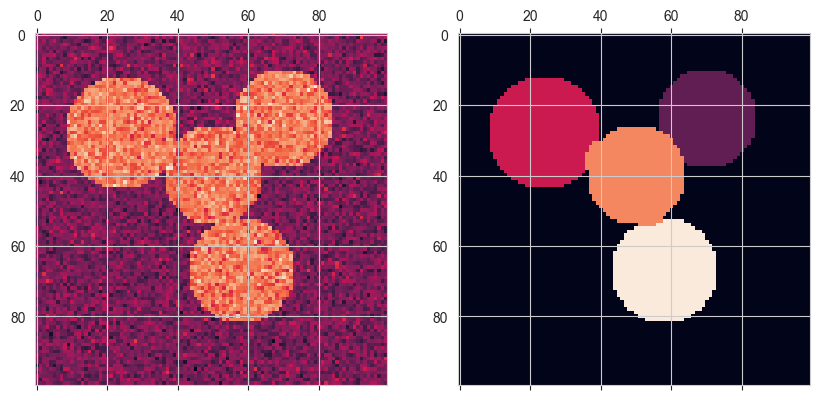

In [5]:
import matplotlib.pyplot as plt

from sklearn.cluster import spectral_clustering

labels = spectral_clustering(graph, n_clusters=4, eigen_solver="arpack")
label_im = np.full(mask.shape, -1.0)
label_im[mask] = labels

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axs[0].matshow(img)
axs[1].matshow(label_im)

plt.show()

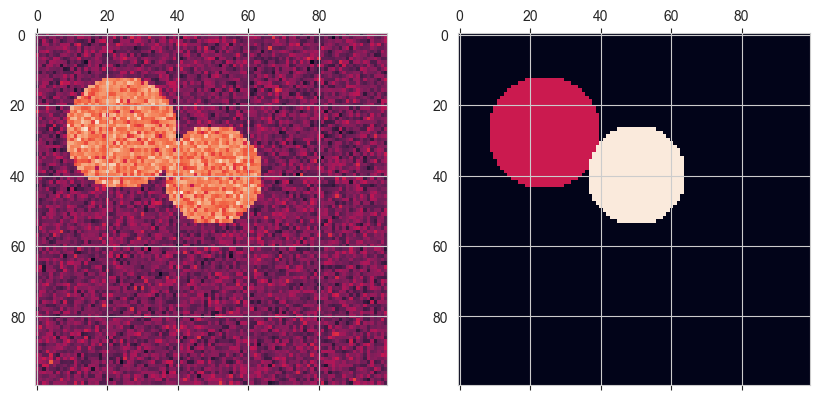

In [6]:
img = circle1 + circle2
mask = img.astype(bool)
img = img.astype(float)

img += 1 + 0.2 * np.random.randn(*img.shape)

graph = image.img_to_graph(img, mask=mask)
graph.data = np.exp(-graph.data / graph.data.std())

labels = spectral_clustering(graph, n_clusters=2, eigen_solver="arpack")
label_im = np.full(mask.shape, -1.0)
label_im[mask] = labels

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axs[0].matshow(img)
axs[1].matshow(label_im)

plt.show()

Automatically created module for IPython interactive environment
ARI: MiniBatchKMeans - dataset0: -0.00066568158561613
ARI: SpectralClustering - dataset0: 1.0
ARI: DBSCAN - dataset0: 1.0
ARI: MiniBatchKMeans - dataset1: 0.4896595757385323
ARI: SpectralClustering - dataset1: 1.0
ARI: DBSCAN - dataset1: 1.0
ARI: MiniBatchKMeans - dataset2: 0.8076764971028273
ARI: SpectralClustering - dataset2: 0.9413237551958699
ARI: DBSCAN - dataset2: 0.5501749954549379
ARI: MiniBatchKMeans - dataset3: 0.6076674498568523
ARI: SpectralClustering - dataset3: 0.9587975200675645
ARI: DBSCAN - dataset3: 0.9749445606497402
ARI: MiniBatchKMeans - dataset4: 1.0
ARI: SpectralClustering - dataset4: 1.0
ARI: DBSCAN - dataset4: 1.0
ARI: MiniBatchKMeans - dataset5: 1.0
ARI: SpectralClustering - dataset5: 1.0
ARI: DBSCAN - dataset5: 1.0


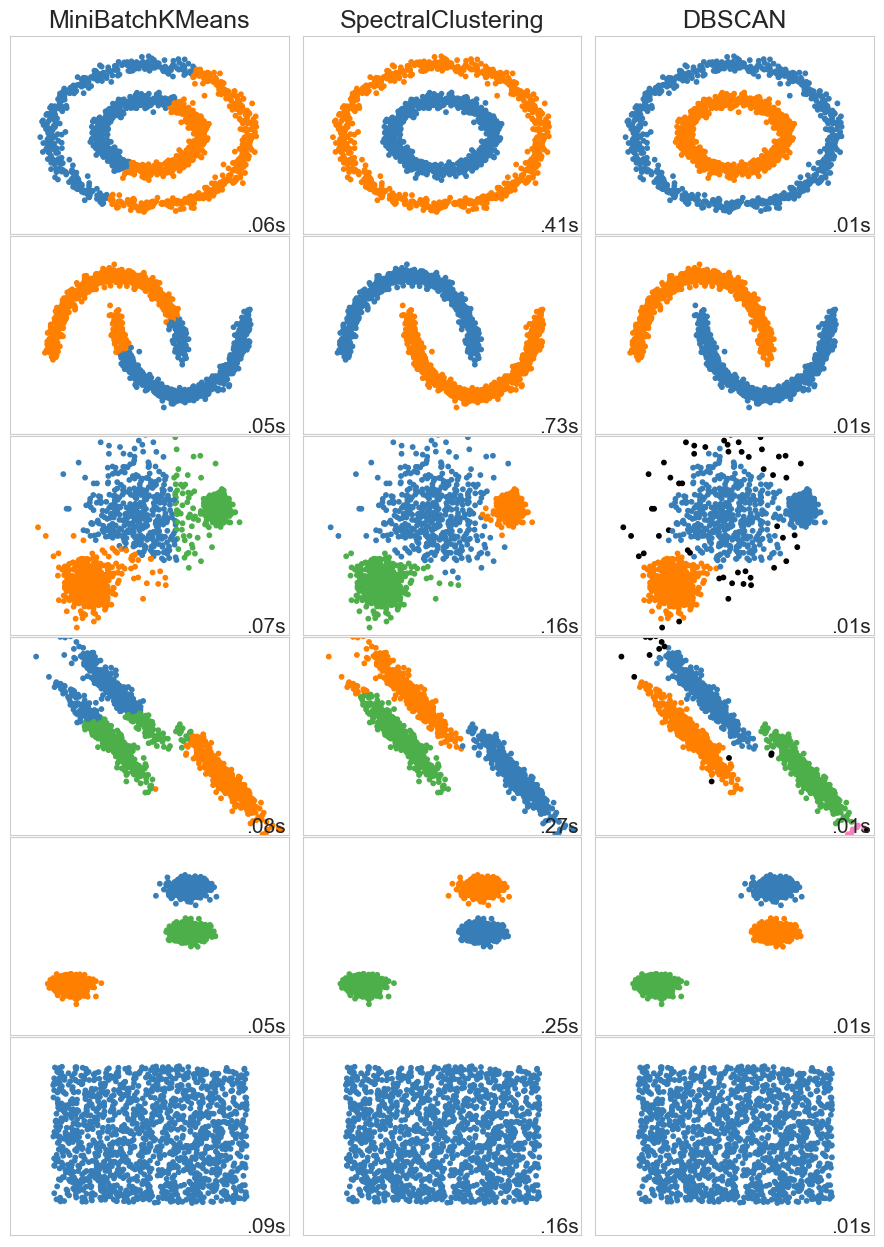

In [7]:
print(__doc__)

import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
from sklearn.metrics import adjusted_rand_score

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), np.zeros(n_samples, dtype=np.int64)

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

# ============
# Set up cluster parameters
# ============
# plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.figure(figsize=(3 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3,
                'min_samples': 20,
                'xi': 0.05,
                'min_cluster_size': 0.1}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2,
                     'min_samples': 20, 'xi': 0.25}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2,
              'min_samples': 5, 'xi': 0.035, 'min_cluster_size': .2}),
    (aniso, {'eps': .15, 'n_neighbors': 2,
             'min_samples': 20, 'xi': 0.1, 'min_cluster_size': .2}),
    (blobs, {}),
    (no_structure, {'n_clusters': 1})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # ============
    # Create cluster objects
    # ============
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])

    clustering_algorithms = (
        ('MiniBatchKMeans', two_means),
        ('SpectralClustering', spectral),
        ('DBSCAN', dbscan)
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning",
                category=FutureWarning
            )
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int64)
        else:
            y_pred = algorithm.predict(X)


        ari_score = adjusted_rand_score(y, y_pred)
        print(f"ARI: {name} - dataset{i_dataset}:", ari_score)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()

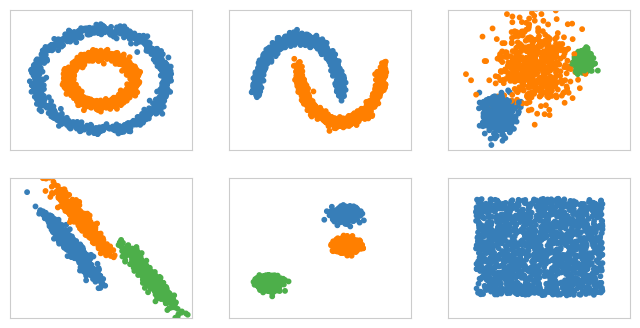

In [8]:
# 设置图形大小
plt.figure(figsize=(8, 4))
for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    plt.subplot(2, 3, i_dataset + 1)

    colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                        '#f781bf', '#a65628', '#984ea3',
                                        '#999999', '#e41a1c', '#dede00']),
                                      int(max(y) + 1))))
    plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y])

    plt.xlim(-2.5, 2.5)
    plt.ylim(-2.5, 2.5)
    plt.xticks(())
    plt.yticks(())

ARI: kmeans - dataset0: 1.0
ARI: discretize - dataset0: 1.0
ARI: kmeans - dataset1: 1.0
ARI: discretize - dataset1: 1.0
ARI: kmeans - dataset2: 0.9413237551958699
ARI: discretize - dataset2: 0.9413237551958699
ARI: kmeans - dataset3: 0.9587975200675645
ARI: discretize - dataset3: 0.9723319883537636
ARI: kmeans - dataset4: 1.0
ARI: discretize - dataset4: 1.0
ARI: kmeans - dataset5: 1.0
ARI: discretize - dataset5: 1.0


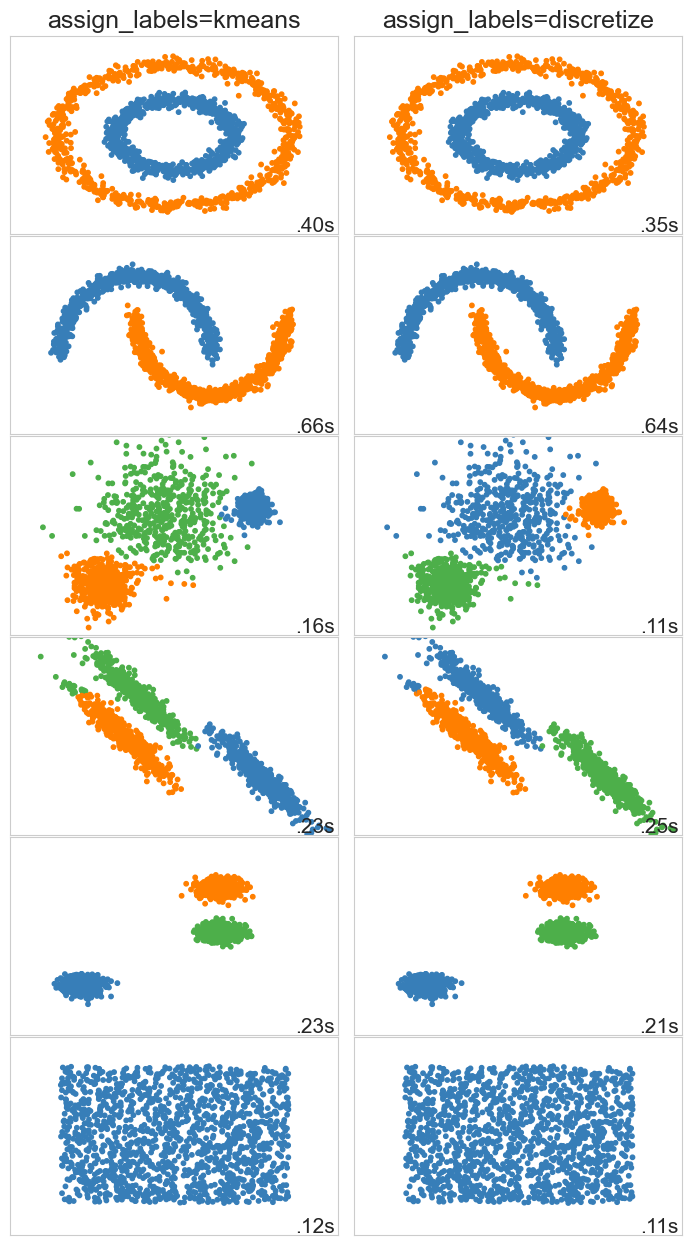

In [9]:
import time
import warnings
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
from sklearn.metrics import adjusted_rand_score

plt.figure(figsize=(2 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)
plot_num = 1
for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # ============
    # Create cluster objects
    # ============

    assign_labels_options = ['kmeans', 'discretize']
    for assign_labels in assign_labels_options:

        spectral = cluster.SpectralClustering(
            n_clusters=params['n_clusters'], eigen_solver='arpack',
            affinity="nearest_neighbors", assign_labels=assign_labels)

        clustering_algorithms =  ('SpectralClustering', spectral)

        name, algorithm = clustering_algorithms
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                   message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning",
                category=FutureWarning
            )
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int64)
        else:
            y_pred = algorithm.predict(X)


        ari_score = adjusted_rand_score(y, y_pred)
        print(f"ARI: {assign_labels} - dataset{i_dataset}:", ari_score)

        plt.subplot(len(datasets), len(assign_labels_options), plot_num)
        if i_dataset == 0:
            plt.title(f'assign_labels={assign_labels}', size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                            '#f781bf', '#a65628', '#984ea3',
                                            '#999999', '#e41a1c', '#dede00']),
                                          int(max(y_pred) + 1))))
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                     transform=plt.gca().transAxes, size=15,
                     horizontalalignment='right')
        plot_num += 1

plt.show()

ARI: 0.05 - dataset0: -0.0006515448738744461
ARI: 0.1 - dataset0: -0.0006604361339365145
ARI: 1 - dataset0: -0.0006230814411831106
ARI: 10 - dataset0: 1.0
ARI: 100 - dataset0: 1.0
ARI: 0.05 - dataset1: 0.4803645451149746
ARI: 0.1 - dataset1: 0.48221643275693415
ARI: 1 - dataset1: 0.5453251342825075
ARI: 10 - dataset1: 1.0
ARI: 100 - dataset1: 1.0
ARI: 0.05 - dataset2: 0.6842983296982337
ARI: 0.1 - dataset2: 0.6996973525071782
ARI: 1 - dataset2: 0.7794682808766807
ARI: 10 - dataset2: 0.9223668999285177
ARI: 100 - dataset2: 1.4269788030111522e-05
ARI: 0.05 - dataset3: 0.8005640215402391
ARI: 0.1 - dataset3: 0.5664762131419024
ARI: 1 - dataset3: 0.5678061118889555
ARI: 10 - dataset3: 0.9625535649973281
ARI: 100 - dataset3: 0.9979993320004471
ARI: 0.05 - dataset4: 1.0
ARI: 0.1 - dataset4: 1.0
ARI: 1 - dataset4: 1.0
ARI: 10 - dataset4: 1.0
ARI: 100 - dataset4: 1.0
ARI: 0.05 - dataset5: 1.0
ARI: 0.1 - dataset5: 1.0
ARI: 1 - dataset5: 1.0
ARI: 10 - dataset5: 1.0
ARI: 100 - dataset5: 1.0


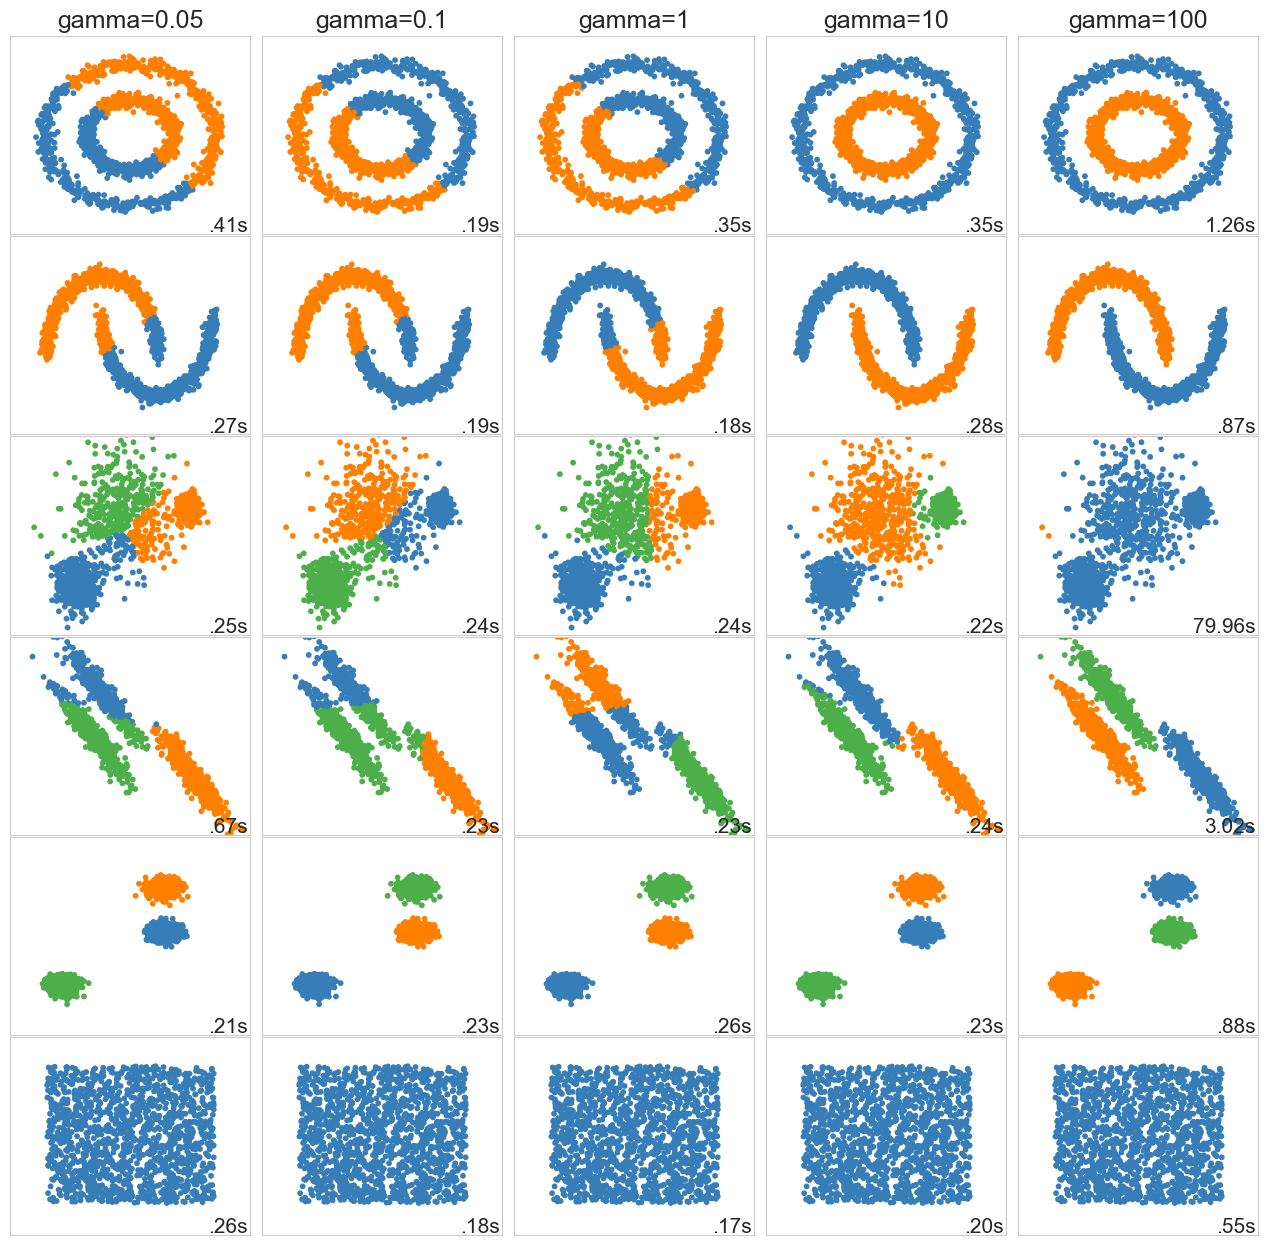

In [10]:
import time
import warnings
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
from sklearn.metrics import adjusted_rand_score

plt.figure(figsize=(5 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)
plot_num = 1
for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # ============
    # Create cluster objects
    # ============

    gammas = [0.05, 0.1, 1, 10, 100]
    for gamma in gammas:

        spectral = cluster.SpectralClustering(
            n_clusters=params['n_clusters'], eigen_solver='arpack',
            affinity="rbf", gamma=gamma)

        clustering_algorithms =  ('SpectralClustering', spectral)

        _, algorithm = clustering_algorithms
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                   message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning",
                category=FutureWarning
            )
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int64)
        else:
            y_pred = algorithm.predict(X)


        ari_score = adjusted_rand_score(y, y_pred)
        print(f"ARI: {gamma} - dataset{i_dataset}:", ari_score)

        plt.subplot(len(datasets), len(gammas), plot_num)
        if i_dataset == 0:
            plt.title(f'gamma={gamma}', size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                            '#f781bf', '#a65628', '#984ea3',
                                            '#999999', '#e41a1c', '#dede00']),
                                          int(max(y_pred) + 1))))
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                     transform=plt.gca().transAxes, size=15,
                     horizontalalignment='right')
        plot_num += 1

plt.show()